

Audio Event Detection Metrics:
Precision: 0.030592734225621414
Recall: 0.16494845360824742
F1 Score: 0.051612903225806445


Mean GT Narration Duration:
3.0081544117647057


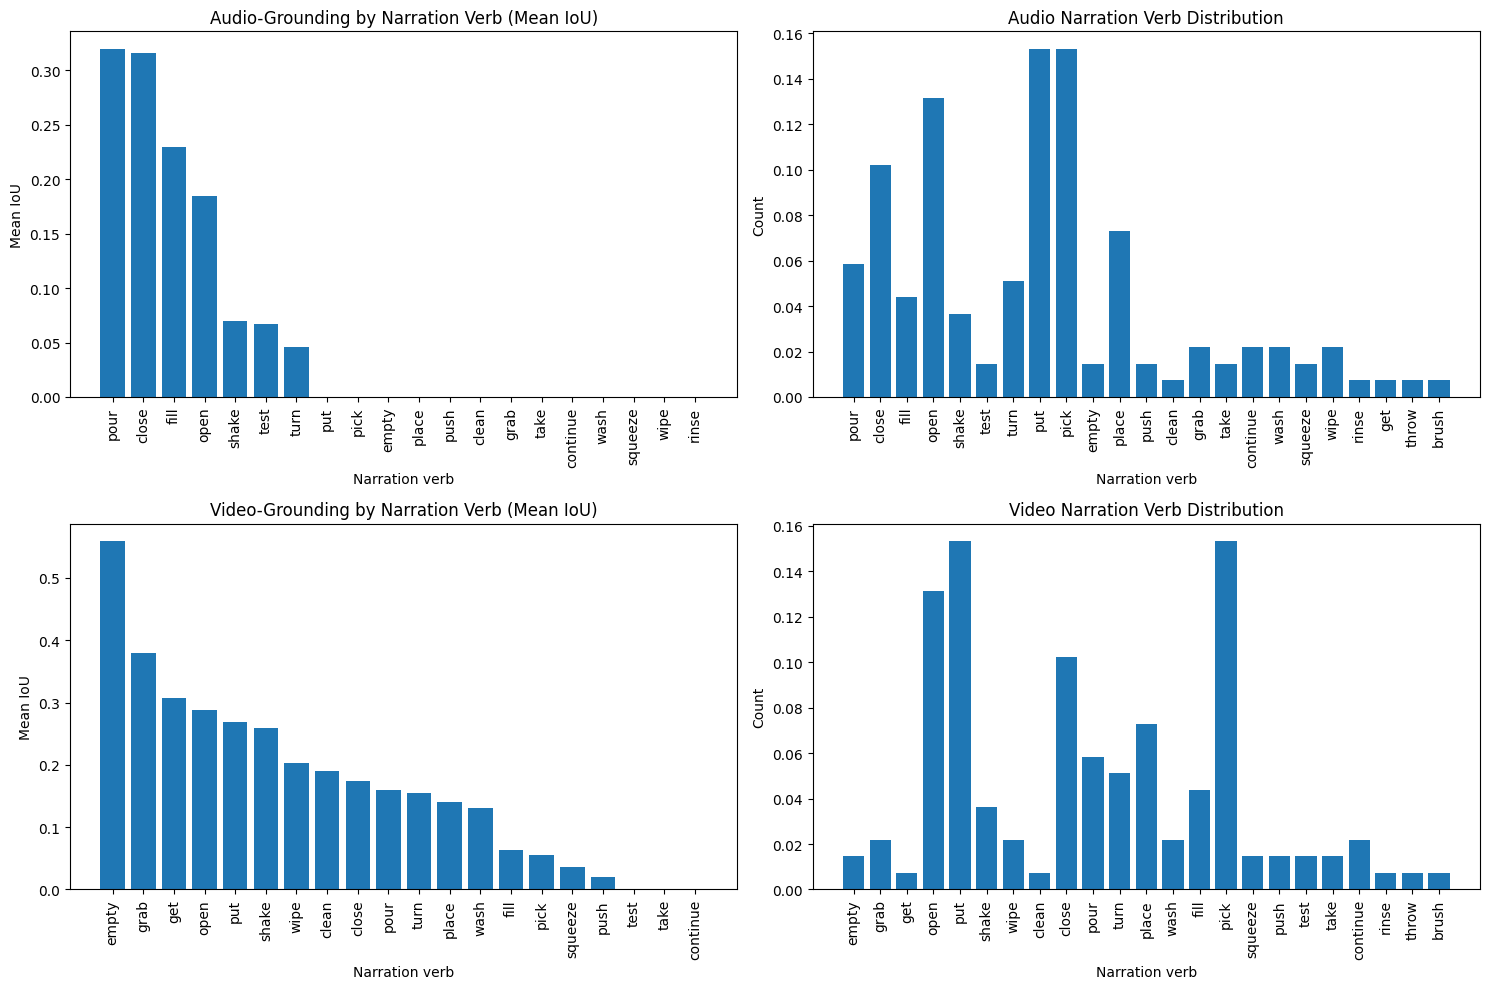

interactive(children=(IntSlider(value=0, description='Window', max=21), Output()), _dom_classes=('widget-inter…

Narration Grounding Metrics:
                             Mean IoU  IoU >= 0.1  IoU >= 0.5  IoU >= 0.7
Method                                                                   
Audio-Assignment             0.091143   20.437956    8.759124    2.919708
Audio-Assignment (filtered)  0.430570   96.551724   41.379310   13.793103
Video-Assignment             0.173415   37.956204   14.598540    4.379562
Video-Assignment (filtered)  0.187676   44.827586   13.793103    3.448276
Baseline                     0.356037   86.131387   25.547445    8.029197
Baseline (filtered)          0.339742   82.758621   24.137931    6.896552


In [11]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import argparse
from ipywidgets import interact, IntSlider, fixed
import sys

def process_verb_iou(df):
    verbs = df['narration'].str.extract(r'\b(\w+)\b', expand=False).unique()
    words_to_delete = ["still", "and"]
    for word in words_to_delete:
        verbs = np.delete(verbs, np.argwhere(verbs == word))  # Exclude non-verb words

    verb_iou = {}
    for verb in verbs:
        verb_df = df[df['narration'].str.contains(f"\\b{verb}\\b")]
        verb_iou[verb] = (len(verb_df), verb_df['IoU'].mean())

    verb_iou = dict(sorted(verb_iou.items(), key=lambda item: item[1][1], reverse=True))
    return pd.DataFrame.from_dict(verb_iou, orient='index', columns=['count', 'mean_IoU'])

def update_plot(window_idx, vis_win_length, audio, sr, audio_grounded_narrations_df,
                 video_grounded_narrations_df, grounding, audio_events_df,
                 audio_annotations_gt):
    # Calculate the start and end time of the window
    start_time = window_idx * vis_win_length
    end_time = start_time + vis_win_length
    
    # Get the audio samples and corresponding timestamps for the window
    window_audio = audio[int(start_time * sr):int(end_time * sr)]
    window_timestamps = np.linspace(start_time, end_time, len(window_audio))
    
    # Plot the audio waveform
    fig, axs = plt.subplots(5, figsize=(15,15))
    axs[0].plot(window_timestamps, window_audio)
    axs[0].set_ylabel('Amplitude')
    axs[0].set_title('Ground Truth Narration Intervals')
    
    #Plot the ground truth narration segments
    for _, row in audio_grounded_narrations_df.iterrows():
        if row['start_seconds'] >= start_time and row['stop_seconds'] <= end_time:
            axs[0].axvspan(row['start_seconds'], row['stop_seconds'], color='red', alpha=0.3)
            mid_point = (row['start_seconds'] + row['stop_seconds']) / 2
            axs[0].annotate(row['narration'],
                        (mid_point, 0),
                        textcoords="offset points",
                        xytext=(0, 40),  # Position text below the waveform
                        ha='center',
                        va='bottom',
                        rotation=20)  # Vertical text for clarity
                        
    # Plot the audio waveform
    axs[1].plot(window_timestamps, window_audio)
    axs[1].set_ylabel('Amplitude')
    axs[1].set_title('Video-Assigned Narration Intervals (EgoVLP)')
    
    #Plot the ground truth narration segments
    for _, row in video_grounded_narrations_df.iterrows():
        start = row['assigned_intervals'][0][0]
        end = row['assigned_intervals'][0][1]
        if start >= start_time and end <= end_time:
            axs[1].axvspan(start, end, color='red', alpha=0.3)
            mid_point = (start + end) / 2
            axs[1].annotate(row['narration'],
                        (mid_point, 0),
                        textcoords="offset points",
                        xytext=(0, 40),  # Position text below the waveform
                        ha='center',
                        va='bottom',
                        rotation=20)  # Vertical text for clarity

    axs[2].plot(window_timestamps, window_audio)
    axs[2].set_ylabel('Amplitude')
    axs[2].set_title('Audio-Assigned Narration Intervals')
            
    # Overlay the predicted narration segments on the plot
    for interval_start, interval_stop, narration in grounding:
        if interval_start >= start_time and interval_stop <= end_time:
            axs[2].axvspan(interval_start, interval_stop, color='red', alpha=0.3)
            mid_point = (interval_start + interval_stop) / 2
            axs[2].annotate(narration,
                        (mid_point, 0),
                        textcoords="offset points",
                        xytext=(0, 40),  # Position text below the waveform
                        ha='center',
                        va='bottom',
                        rotation=20)  # Vertical text for clarity

    axs[3].plot(window_timestamps, window_audio)
    axs[3].set_ylabel('Amplitude')
    axs[3].set_title('Predicted Audio Events')
    
    #Plot the predicted audio events
    for _, row in audio_events_df.iterrows():
        if row['start_seconds'] >= start_time and row['stop_seconds'] <= end_time:
            axs[3].axvspan(row['start_seconds'], row['stop_seconds'], color='red', alpha=0.3)
            mid_point = (row['start_seconds'] + row['stop_seconds']) / 2
            axs[3].annotate(row['description'],
                        (mid_point, 0),
                        textcoords="offset points",
                        xytext=(0, 40),  # Position text below the waveform
                        ha='center',
                        va='bottom',
                        rotation=20)  # Vertical text for clarity

    axs[4].plot(window_timestamps, window_audio)
    axs[4].set_xlabel('Time (seconds)')
    axs[4].set_ylabel('Amplitude')
    axs[4].set_title('Ground Truth Audio Events')  

    #Plot the ground truth audio events
    for _, row in audio_annotations_gt.iterrows():
        if row['start_seconds'] >= start_time and row['stop_seconds'] <= end_time:
            axs[4].axvspan(row['start_seconds'], row['stop_seconds'], color='red', alpha=0.3)
            mid_point = (row['start_seconds'] + row['stop_seconds']) / 2
            axs[4].annotate(row['class'],
                        (mid_point, 0),
                        textcoords="offset points",
                        xytext=(0, 40),  # Position text below the waveform
                        ha='center',
                        va='bottom',
                        rotation=20)  # Vertical text for clarity
    
    fig.tight_layout()
    
def compute_union_intervals_and_max_duration(df, narration_col='narration', intervals_col='assigned_intervals'):
    grounding = []
    max_interval_narr = (None, 0)

    for _, row in df.iterrows():
        narration = row[narration_col]
        assigned_intervals = row[intervals_col]
        
        if assigned_intervals:
            min_start = float('inf')
            max_stop = float('-inf')
            
            for interval in assigned_intervals:
                interval_start, interval_stop = interval
                if interval_start < min_start:
                    min_start = interval_start
                if interval_stop > max_stop:
                    max_stop = interval_stop
            
            union_duration = max_stop - min_start
            grounding.append((min_start, max_stop, narration))
            
            if union_duration > max_interval_narr[1]:
                max_interval_narr = (narration, union_duration)

    return grounding, max_interval_narr

def calculate_audio_event_iou(segment1, segment2):
    start_max = max(segment1[0], segment2[0])
    end_min = min(segment1[1], segment2[1])
    intersection = max(0, end_min - start_max)
    union = (segment1[1] - segment1[0]) + (segment2[1] - segment2[0]) - intersection
    return intersection / union if union != 0 else 0

def interval_intersection(A, B):
    """ Find the intersection of two interval lists """
    i, j, intersection = 0, 0, []
    while i < len(A) and j < len(B):
        a_start, a_end = A[i]
        b_start, b_end = B[j]
        # Find the intersection range
        start = max(a_start, b_start)
        end = min(a_end, b_end)
        if start <= end:  # There is an overlap
            intersection.append((start, end))
        # Move to next interval in A or B
        if a_end < b_end:
            i += 1
        else:
            j += 1
    return intersection

def merge_intervals(intervals):
    """ Merge overlapping intervals into a single list of intervals """
    if not intervals:
        return []
    # Sort intervals based on start time
    intervals.sort(key=lambda x: x[0])
    merged = [intervals[0]]
    for current_start, current_end in intervals[1:]:
        last_start, last_end = merged[-1]
        # If current interval overlaps with the last one, merge them
        if current_start <= last_end:
            merged[-1] = (last_start, max(last_end, current_end))
        else:
            merged.append((current_start, current_end))
    return merged

def compute_iou(row, mode='baseline'):
    """ Compute the IoU based on ground truth and assigned intervals """
    ground_truth_intervals = [(row['start_seconds'], row['stop_seconds'])]
    if mode=="baseline":
        assigned_intervals = [[row['baseline_start'], row['baseline_stop']]]
    else:
        assigned_intervals = row['assigned_intervals']
    if not assigned_intervals:
        return 0  # No IoU if there are no assigned intervals
    # Merge intervals to find the union
    union_intervals = merge_intervals(ground_truth_intervals + assigned_intervals)
    intersection_intervals = interval_intersection(ground_truth_intervals, assigned_intervals)
    # Calculate areas
    intersection_area = sum(end - start for start, end in intersection_intervals)
    union_area = sum(end - start for start, end in union_intervals)
    if union_area == 0:
        return 0  # Avoid division by zero
    return intersection_area / union_area

def main():
    parser = argparse.ArgumentParser(description="Process audio and video annotations with various grounding and evaluation parameters.")
    
    # File-loading options
    parser.add_argument('--participant_id', type=str, help='Participant ID')
    parser.add_argument('--video_num', type=str, help='Video number')
    parser.add_argument('--sr', type=int, default=24000, help='Audio sampling rate')
    parser.add_argument('--audio_annotations_train_file', type=str, default="/private/home/arjunrs1/epic-sounds-annotations/EPIC_Sounds_train.pkl", help='Path to the training audio annotations file')
    parser.add_argument('--audio_annotations_val_file', type=str, default="/private/home/arjunrs1/epic-sounds-annotations/EPIC_Sounds_validation.pkl", help='Path to the validation audio annotations file')
    
    # Options
    parser.add_argument('--N', type=int, default=None, help='Number of seconds to trim the audio')
    parser.add_argument('--best_iou_threshold', type=float, default=0.5, help='Threshold for best IOU for audio event detection evaluation')
    parser.add_argument('--use_clustered_bounds', action='store_true', help='Use clustered bounds for audio event detection')
    parser.add_argument('--dendrogram_height', type=float, default=0.8, help='Dendrogram height for clustering')
    parser.add_argument('--use_llama_assignment', action='store_true', help='Use Llama model for assignment')
    parser.add_argument('--audio_assignment_scheme', type=str, default="best", choices=['best', 'random'], help='Scheme for assigning audio to narrations')
    parser.add_argument('--similarity_threshold', type=float, default=0.3, help='Similarity threshold for video grounding')
    parser.add_argument('--feature_stride', type=float, default=0.5, help='Feature stride for video grounding')
    parser.add_argument('--feature_duration', type=float, default=1.0, help='Feature duration for video grounding')
    parser.add_argument('--num_unique_narrs_for_disp', type=int, default=20, help='Number of unique narrations for display')
    parser.add_argument('--vis_win_length', type=int, default=20, help='Window length for visualization')

    args = parser.parse_args()

    # Construct video_id using provided arguments
    video_id = f"{args.participant_id}_{args.video_num}"

    audio_path = f'/private/home/arjunrs1/EPIC-SOUNDS/{video_id}.wav'
    audio, sr = librosa.load(audio_path, sr=args.sr)
    if args.N is None:
        args.N = int(len(audio) / args.sr)
    N_seconds_samples = args.N * args.sr
    audio = audio[:N_seconds_samples]

    # Load annotations
    audio_annotations_train = pd.read_pickle(args.audio_annotations_train_file)
    audio_annotations_val = pd.read_pickle(args.audio_annotations_val_file)
    audio_annotations = pd.concat([audio_annotations_train, audio_annotations_val], axis=0)

    audio_annotations_gt = audio_annotations[audio_annotations.video_id==video_id]
    audio_annotations_gt = audio_annotations_gt[['start_timestamp', 'stop_timestamp', 'description', 'class', 'class_id']].copy()
    audio_annotations_gt['start_seconds'] = pd.to_datetime(audio_annotations_gt['start_timestamp'], format='%H:%M:%S.%f').dt.time
    audio_annotations_gt['stop_seconds'] = pd.to_datetime(audio_annotations_gt['stop_timestamp'], format='%H:%M:%S.%f').dt.time
    audio_annotations_gt['start_seconds'] = audio_annotations_gt['start_seconds'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second + x.microsecond / 1e6)
    audio_annotations_gt['stop_seconds'] = audio_annotations_gt['stop_seconds'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second + x.microsecond / 1e6)

    #--------------------------------------------------------load in predicted audio events:-------------------------------------------------------
    with open(f"/private/home/arjunrs1/epic-sounds-annotations/audio_event_detection_predictions/{video_id}/dendrogram_height={args.dendrogram_height}.pkl", "rb") as f:
        audio_events_df = pickle.load(f)

    #--------------------------------------------------------load in predicted audio grounding:-------------------------------------------------------
    #Load in narrations_df here from generate_audio_grounding.py script output file
    with open(f"/private/home/arjunrs1/epic-sounds-annotations/audio_grounded_narrations/{video_id}/llama_assigned={args.use_llama_assignment}_clustered_bounds={args.use_clustered_bounds}_audio_assignment={args.audio_assignment_scheme}.pkl", "rb") as f:
        audio_grounded_narrations_df = pickle.load(f)

    #--------------------------------------------------------load in predicted video grounding:-------------------------------------------------------
    #Load in narrations_df here from generate_frame_grounding.py script output file
    with open(f"/private/home/arjunrs1/epic-sounds-annotations/video_grounded_narrations/{video_id}/similarity_threshold={args.similarity_threshold}_feature_duration={args.feature_duration}_feature_stride={args.feature_stride}.pkl", "rb") as f:
        video_grounded_narrations_df = pickle.load(f)

    #--------------------------------------------------------evaluate audio event merging against GT:-------------------------------------------------------
    matches = []
    for index, pred in audio_events_df.iterrows():
        best_iou = 0
        best_gt = None
        for _, gt in audio_annotations_gt.iterrows():
            if pred['description'] == gt['class']:
                iou = calculate_audio_event_iou((pred['start_seconds'], pred['stop_seconds']), (gt['start_seconds'], gt['stop_seconds']))
                if iou > best_iou:
                    best_iou = iou
                    best_gt = gt
        if best_iou > args.best_iou_threshold:
            matches.append((pred, best_gt, best_iou))

    # Convert matches to DataFrame if needed for further analysis
    matches_df = pd.DataFrame(matches, columns=['Prediction', 'Ground Truth', 'IoU'])

    tp = len(matches_df)
    fp = len(audio_events_df) - tp
    fn = len(audio_annotations_gt) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\n")
    print("Audio Event Detection Metrics:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")
    print("\n")

    #fewer segments leads to higher precision but lower recall (and lower f1 score). Which do we care more about for our purposes?
    ### Format DataFrames for analysis:

    #--------------------------------------------------compute IoU for predicted grounded narrations:-------------------------------------------------------
    # Apply IoU computation to the dataframe
    audio_grounded_narrations_df['IoU'] = audio_grounded_narrations_df.apply(compute_iou, mode="audio_mediated", axis=1)
    video_grounded_narrations_df['IoU'] = video_grounded_narrations_df.apply(compute_iou, mode="frame_mediated", axis=1)

    #-----------------compute naive baseline (uniform) and filter narrations to only those which received an audio event-------------------------------------------------------
    # Number of narrations
    num_narrations = len(audio_grounded_narrations_df)

    # Compute segment length
    segment_length = args.N / num_narrations
    mean_gt_narration_duration = audio_grounded_narrations_df.sort_values(by='narr_seconds')['narr_seconds'].diff().shift(-1).iloc[:-1].mean()

    print("Mean GT Narration Duration:")
    print(mean_gt_narration_duration)

    # Assign segments to narrations
    audio_grounded_narrations_df['baseline_start'] = audio_grounded_narrations_df['narr_seconds'] - mean_gt_narration_duration / 2
    audio_grounded_narrations_df['baseline_stop'] = audio_grounded_narrations_df['narr_seconds'] + mean_gt_narration_duration / 2

    video_grounded_narrations_df['baseline_start'] = np.arange(0, args.N, segment_length)
    video_grounded_narrations_df['baseline_stop'] = video_grounded_narrations_df['baseline_start'] + segment_length

    # Apply IoU calculation to the dataframe for baseline
    audio_grounded_narrations_df['baseline_IoU'] = audio_grounded_narrations_df.apply(compute_iou, axis=1)
    video_grounded_narrations_df['baseline_IoU'] = video_grounded_narrations_df.apply(compute_iou, axis=1)

    # Filter out rows where 'assigned_intervals' is not empty (i.e., no audio events were assigned to that narration)
    filtered_narrations = audio_grounded_narrations_df[audio_grounded_narrations_df['assigned_intervals'].apply(bool)]
    video_grounded_narrations_filtered_df = video_grounded_narrations_df.loc[filtered_narrations.index]
    ### IoU Metrics:

    #------------------------------compute IoU @ thresholds for our method and baselines on filtered and full set of narrations:-------------------------------------------------------
    # Define IoU thresholds
    iou_thresholds = [0.1, 0.5, 0.7]

    # Metrics for unfiltered audio-assignment
    audio_assignment_metrics = {
        'Mean IoU': audio_grounded_narrations_df['IoU'].mean(),
        **{f'IoU >= {threshold}': (audio_grounded_narrations_df[audio_grounded_narrations_df['IoU'] >= threshold].shape[0] / audio_grounded_narrations_df.shape[0] * 100) for threshold in iou_thresholds}
    }

    # Metrics for filtered audio-assignment
    audio_assignment_filtered_metrics = {
        'Mean IoU': filtered_narrations['IoU'].mean(),
        **{f'IoU >= {threshold}': (filtered_narrations[filtered_narrations['IoU'] >= threshold].shape[0] / filtered_narrations.shape[0] * 100) for threshold in iou_thresholds}
    }

    # Metrics for unfiltered video-assignment
    video_assignment_metrics = {
        'Mean IoU': video_grounded_narrations_df['IoU'].mean(),
        **{f'IoU >= {threshold}': (video_grounded_narrations_df[video_grounded_narrations_df['IoU'] >= threshold].shape[0] / video_grounded_narrations_df.shape[0] * 100) for threshold in iou_thresholds}
    }

    # Metrics for filtered video-assignment
    video_assignment_filtered_metrics = {
        'Mean IoU': video_grounded_narrations_filtered_df['IoU'].mean(),
        **{f'IoU >= {threshold}': (video_grounded_narrations_filtered_df[video_grounded_narrations_filtered_df['IoU'] >= threshold].shape[0] / video_grounded_narrations_filtered_df.shape[0] * 100) for threshold in iou_thresholds}
    }

    # Metrics for baseline (unfiltered)
    baseline_metrics = {
        'Mean IoU': audio_grounded_narrations_df['baseline_IoU'].mean(),
        **{f'IoU >= {threshold}': (audio_grounded_narrations_df[audio_grounded_narrations_df['baseline_IoU'] >= threshold].shape[0] / audio_grounded_narrations_df.shape[0] * 100) for threshold in iou_thresholds}
    }

    # Metrics for baseline (filtered)
    baseline_filtered_metrics = {
        'Mean IoU': filtered_narrations['baseline_IoU'].mean(),
        **{f'IoU >= {threshold}': (filtered_narrations[filtered_narrations['baseline_IoU'] >= threshold].shape[0] / filtered_narrations.shape[0] * 100) for threshold in iou_thresholds}
    }

    # Compile into DataFrame
    metrics_df = pd.DataFrame({
        'Method': ['Audio-Assignment', 'Audio-Assignment (filtered)', 'Video-Assignment', 'Video-Assignment (filtered)', 'Baseline', 'Baseline (filtered)'],
        **{key: [audio_assignment_metrics[key], audio_assignment_filtered_metrics[key], video_assignment_metrics[key], video_assignment_filtered_metrics[key], baseline_metrics[key], baseline_filtered_metrics[key]] for key in audio_assignment_metrics}
    })

    # Set 'Method' as index
    metrics_df.set_index('Method', inplace=True)

    #----------------------------------------------merge audio intervals and store in grounding:-------------------------------------------------------
    grounding = []
    max_interval_narr = (None, 0)
    for _, row in audio_grounded_narrations_df.iterrows():
        narration = row['narration']
        assigned_intervals = row['assigned_intervals']
        
        # Iterate over assigned intervals
        for interval in assigned_intervals:
            interval_start, interval_stop = interval

        if assigned_intervals:
            grounding.append((interval_start, interval_stop, narration))
            if interval_stop - interval_start > max_interval_narr[1]:
                max_interval_narr = (narration, interval_stop - interval_start)

    grounding, max_interval_narr = compute_union_intervals_and_max_duration(audio_grounded_narrations_df)

    # Process data for both audio and video
    audio_verb_iou = process_verb_iou(audio_grounded_narrations_df)
    video_verb_iou = process_verb_iou(video_grounded_narrations_df)

    # Create a single figure with 4 subplots (2x2 grid)
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    # Audio Grounding Plots
    axs[0, 0].bar(x=audio_verb_iou.index[:args.num_unique_narrs_for_disp], height=audio_verb_iou['mean_IoU'][:args.num_unique_narrs_for_disp])
    axs[0, 0].set_xticks(range(len(audio_verb_iou.index[:args.num_unique_narrs_for_disp])))
    axs[0, 0].set_xticklabels(audio_verb_iou.index[:args.num_unique_narrs_for_disp], rotation=90, fontsize=10)
    axs[0, 0].set_xlabel("Narration verb")
    axs[0, 0].set_ylabel("Mean IoU")
    axs[0, 0].set_title("Audio-Grounding by Narration Verb (Mean IoU)")

    axs[0, 1].bar(x=audio_verb_iou.index, height=audio_verb_iou['count']/len(audio_grounded_narrations_df))
    axs[0, 1].set_xticks(range(len(audio_verb_iou)))
    axs[0, 1].set_xticklabels(audio_verb_iou.index, rotation=90)
    axs[0, 1].set_xlabel("Narration verb")
    axs[0, 1].set_ylabel("Count")
    axs[0, 1].set_title("Audio Narration Verb Distribution")

    # Video Grounding Plots
    axs[1, 0].bar(x=video_verb_iou.index[:args.num_unique_narrs_for_disp], height=video_verb_iou['mean_IoU'][:args.num_unique_narrs_for_disp])
    axs[1, 0].set_xticks(range(len(video_verb_iou.index[:args.num_unique_narrs_for_disp])))
    axs[1, 0].set_xticklabels(video_verb_iou.index[:args.num_unique_narrs_for_disp], rotation=90, fontsize=10)
    axs[1, 0].set_xlabel("Narration verb")
    axs[1, 0].set_ylabel("Mean IoU")
    axs[1, 0].set_title("Video-Grounding by Narration Verb (Mean IoU)")

    axs[1, 1].bar(x=video_verb_iou.index, height=video_verb_iou['count']/len(video_grounded_narrations_df))
    axs[1, 1].set_xticks(range(len(video_verb_iou)))
    axs[1, 1].set_xticklabels(video_verb_iou.index, rotation=90)
    axs[1, 1].set_xlabel("Narration verb")
    axs[1, 1].set_ylabel("Count")
    axs[1, 1].set_title("Video Narration Verb Distribution")

    plt.tight_layout()
    plt.show()

    # Create the slider widget
    window_slider = IntSlider(min=0, max=int(args.N/args.vis_win_length), step=1, value=0, description='Window')

    # Create the interactive plot
    interactive_plot = interact(update_plot, window_idx=window_slider,
                                        vis_win_length=fixed(args.vis_win_length),
                                        audio=fixed(audio),
                                        sr=fixed(args.sr),
                                        audio_grounded_narrations_df=fixed(audio_grounded_narrations_df),
                                        video_grounded_narrations_df=fixed(video_grounded_narrations_df),
                                        grounding=fixed(grounding),
                                        audio_events_df=fixed(audio_events_df),
                                        audio_annotations_gt=fixed(audio_annotations_gt))
    print("Narration Grounding Metrics:")
    print(metrics_df)
    
if __name__ == "__main__":
    real_argv = sys.argv
    sys.argv = ['visualize_grounding.ipynb', '--participant_id', 'P03', '--video_num', '02']
    main()

In [12]:
""" 
Audio grounded narrations top performing verbs:
P06_05: Chop, cut, spread, open, close, pour
P04_01: Slice, open, close
P03_02: Pour, close, fill, open, shake
P02_01: Empty, close, open, put
P01_01: 

Video grounded narrations top performing verbs:
P06_05: Peel, chop, wash, take, put, spread, close
P04_01: Select, scrape, look, pour, fold, drain, pull, poke, rip, open
P03_02: Empty, grab, get, open, put, shake, wipe, clean, close, pour, turn, place, wash
P02_01: Walk, return, pick, open, put, scoop, stir, close, hold
P01_01:  
 """

' \nAudio grounded narrations top performing verbs:\nP06_05: Chop, cut, spread, open, close, pour\nP04_01: Slice, open, close\nP03_02: Pour, close, fill, open, shake\nP02_01: Empty, close, open, put\nP01_01: \n\nVideo grounded narrations top performing verbs:\nP06_05: Peel, chop, wash, take, put, spread, close\nP04_01: Select, scrape, look, pour, fold, drain, pull, poke, rip, open\nP03_02: Empty, grab, get, open, put, shake, wipe, clean, close, pour, turn, place, wash\nP02_01: Walk, return, pick, open, put, scoop, stir, close, hold\nP01_01:  \n '

In [13]:
#Notes on sounding actions:
""" 
Sounding actions learns embeddings from audio and video and language that capture the action-ness and visual-ness of an action
While training on EPIC-SOUNDS learns embeddings for sound semantics, the embeddings learned here are trained to
capture information about 1) Whether the sound is visually demonstrated, and 2) Whether it corresponds to the language description
(it is an action sound). It primarily has significance in conjuncction with other modality encoders, telling whetherr
the sound and a video clip correspond to a sound that is visually demonstrated, or with a sound and a language tag whether
the language tag produces a sounding action.

We can use this in two ways:
1) In addition to pure audio semantic features that are output from ASF, we can append this embedding to capture whether
it is a sound that is visually demonstrated by a person's action. This is useful for our setting, but we can't directly use it for computing similarity

2) In sounding action discovery, they compute video/language embeddings, and audio embeddings (of contamparenous timme slices)
and see where they have high similarity, which correspond to action sounding regions of the video. Our goal is to 
identify narrations that should have a sound, and also to identify sounds that should have a narration, and determine
which sounds "belong" to which narration. Maybe try replacing the text similarity with the sounding action representation
and compute similarity in this space. 

In other words: Use sounding actions embeddings to determinee "sounding regions" where the action sounds are visually demonstrated (whatever they are) - then identify the action sounds in these regions,
find which narration they belong to, and assign intervals in that manner.
    NOTE: But this implies that currently, the main issue is that awe are assigning audio events which are not even demonstrated to the narrations, which hurts things. Butt remember we introduced thresholds
    for assignment, so our approach can simply ignore audio events if it wants to. Would this really solve the problem we are facing? Look at visual examples to see..

3) As K said introducing temporal information into the audio (beginning of sound, middle, end) woudl be useful in grounding narrations
via sounds. However, this may be too subtle for vast majority of sounds.
 """

' \nSounding actions learns embeddings from audio and video and language that capture the action-ness and visual-ness of an action\nWhile training on EPIC-SOUNDS learns embeddings for sound semantics, the embeddings learned here are trained to\ncapture information about 1) Whether the sound is visually demonstrated, and 2) Whether it corresponds to the language description\n(it is an action sound). It primarily has significance in conjuncction with other modality encoders, telling whetherr\nthe sound and a video clip correspond to a sound that is visually demonstrated, or with a sound and a language tag whether\nthe language tag produces a sounding action.\n\nWe can use this in two ways:\n1) In addition to pure audio semantic features that are output from ASF, we can append this embedding to capture whether\nit is a sound that is visually demonstrated by a person\'s action. This is useful for our setting, but we can\'t directly use it for computing similarity\n\n2) In sounding action d

In [14]:
#notes on separating chirp/chat:
""" 
The idea is that they unsupervised learn to spatially ground audio in video. They do this by computing video features (spatial)
and computing (temporal) audio features, and computing an "inner volume" of the features, showing product between each spatio-temporal
video feature and each audio feature. Then, by contrastively comparing against mis-matched audio/video, the model learns
to produce high activations where the spatio-temporal video feature and the corresponding audio faeture activate
e.g if a dog is barking in the first second of video, then the volume will have high activation at that spatio-temporal
region of the constructed volume. 
 """

' \nThe idea is that they unsupervised learn to spatially ground audio in video. They do this by computing video features (spatial)\nand computing (temporal) audio features, and computing an "inner volume" of the features, showing product between each spatio-temporal\nvideo feature and each audio feature. Then, by contrastively comparing against mis-matched audio/video, the model learns\nto produce high activations where the spatio-temporal video feature and the corresponding audio faeture activate\ne.g if a dog is barking in the first second of video, then the volume will have high activation at that spatio-temporal\nregion of the constructed volume. \n '